### Logistic Regression 

Using a logistic regression model to predict whether a student gets admitted into a university.

Datset: Exam Scores Dataset consisting of the scores on two exams for 102 students. 

In [290]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
print('Tested with:')
print('Python', sys.version)
print({x.__name__: x.__version__ for x in [np, matplotlib]})

Tested with:
Python 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
{'numpy': '1.19.2', 'matplotlib': '3.3.2'}


**Visualizing the data**

Two-dimensional visualization of dataset.

In [291]:
def read_classification_csv_data(fn, add_ones=False):
    
    # Reading data from CSV
    data = np.loadtxt(fn, delimiter=',')
    X_, y_ = data[:, :-1], data[:, -1, None] 

    print(X_.shape, X_.min(), X_.max(), X_.dtype)
    print(y_.shape, y_.min(), y_.max(), y_.dtype) # NOTE: y is a float-type

    X = np.insert(X_, X_.shape[1], 1, axis=1) if add_ones else X_ # Concatenation of column of 1's into dataset
    y = y_.astype(np.int32) # y-type conversion
    return X, y
    
X_data, y_data = read_classification_csv_data('ex2data1.txt', add_ones=True)
print(X_data.shape, X_data.min(), X_data.max(), X_data.dtype)
print(y_data.shape, y_data.min(), y_data.max(), y_data.dtype)

(100, 2) 30.05882244669796 99.82785779692128 float64
(100, 1) 0.0 1.0 float64
(100, 3) 1.0 99.82785779692128 float64
(100, 1) 0 1 int32


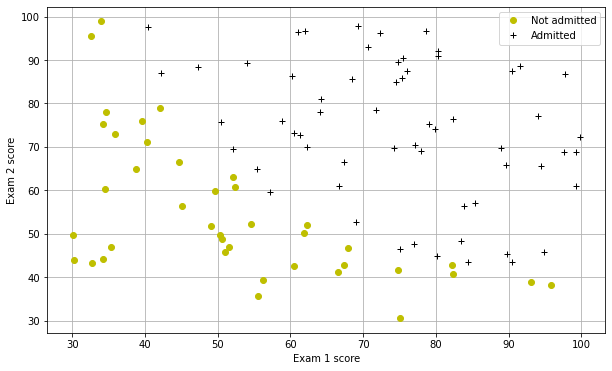

In [292]:
# Labeled scatter plot of dataset

def plot_data(X, y, labels, markers, xlabel, ylabel, figsize=(10, 6), ax=None):
    if figsize is not None:
        plt.figure(figsize=figsize)

    ax = ax or plt.gca()
    for label_id, (label, marker) in enumerate(zip(labels, markers)):        
        ax.plot(*X[y.ravel()==label_id, :2].T, marker, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend()
    ax.grid(True)
    
student_plotting_spec = {
    'X': X_data,
    'y': y_data, 
    'xlabel': 'Exam 1 score', 
    'ylabel': 'Exam 2 score',
    'labels': ['Not admitted', 'Admitted'], 
    'markers': ['yo', 'k+'], 
    'figsize': (10, 6)
}
    
plot_data(**student_plotting_spec)
plt.show()

**Hypothesis Function**

Logistic Regression hypothesis function: 

$h_\theta(x) = g(\theta^Tx)$

where function g is the sigmoid function. The sigmoid function is defined as:

$g(z) = \dfrac{1}{1+e^{-z}}$

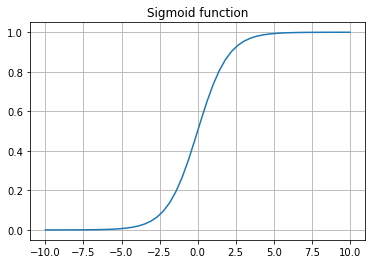

In [293]:
# Definition of sigmoid function and example plot

def sigmoid(x):
    
    if (x.ndim > 1):
        x = x.reshape(1, np.prod(np.shape(x)))
    x = np.squeeze(x)

    return x, scipy.special.expit(x)

def check_that_sigmoid_f(f):
    
    x_test = np.linspace(-10, 10, 50)
    x_test = np.reshape(x_test, [5,10])
    x_test, sigm_test = f(x_test)
    plt.plot(x_test, sigm_test)
    plt.title("Sigmoid function")
    plt.grid(True)
    plt.show()
    
check_that_sigmoid_f(sigmoid)

**Cost Function**

Using binary logistic loss function:

$J(\theta) \ = \ \frac{1}{m} \ \sum_{i=1}^{m} \ [ \ -y^{(i)} log(h_\theta(x^{(i)})) \ - \ (1 - y^{(i)})log(1-h_\theta(x^{(i)})) \ ]$

Differentiating with respect to $\theta_{j}$, where $j = 1...n$

$\frac{\partial J(\theta)}{\partial \theta_{j}} \ = \ \frac{1}{m} \ \sum_{i=1}^{m} \ (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)}$

where $m$ is the number of points and $n$ is the number of features.

In [294]:
# Definition of model functions 

def hypothesis_function(x, theta):

    result = np.matmul(theta.T,x.T)
    x,h0 = sigmoid(result)

    return h0

    
def binary_logistic_loss(y, y_pred):

    y = np.squeeze(y)
    y_pred = np.squeeze(y_pred)
    assert np.shape(y_pred) == np.shape(y)
    y, y_pred = y.astype(np.float64), y_pred.astype(np.float64)
    CONSTANT = 0.000001
    y_pred = np.clip(y_pred, 0+CONSTANT, 1-CONSTANT)
    
    return (1/np.prod(np.shape(y_pred))*np.sum(-y*np.log(y_pred) - (1-y)*np.log(1-y_pred)))
    
def logistic_loss_theta_grad(x, y, h, theta):

    
    theta = theta.reshape((-1,1)) # reshape theta: n by 1
    y_pred = h(x, theta)
    y_pred = np.reshape(y_pred, [np.shape(y_pred)[0],1])
    point_wise_grads = (y_pred-y)*x
    grad = np.mean(point_wise_grads, axis=0)[:, None]
    assert grad.shape == theta.shape
    
    return grad.ravel()    

def logistic_loss_theta(x, y, h, theta):
    
    theta = theta.reshape((-1,1)) # reshape theta: n by 1
    
    return binary_logistic_loss(y, h(x, theta))


In [295]:
# Check that with theta as zeros, cost is about 0.693:
theta_init = np.zeros((X_data.shape[1], 1))
print(logistic_loss_theta(X_data, y_data, hypothesis_function, theta_init))
print(logistic_loss_theta_grad(X_data, y_data, hypothesis_function, theta_init))

0.6931471805599453
[-12.00921659 -11.26284221  -0.1       ]


**Optimization**

Optimization using the Optimize library in SciPy 

In [296]:
import scipy.optimize
from functools import partial

In [297]:
def optimize(theta_init, loss, loss_grad, max_iter=10000, print_every=1000, optimizer_fn=None, show=False):
        
    theta = theta_init.copy()
    opt_args = {'x0': theta, 'fun': loss, 'jac': loss_grad, 'options': {'maxiter': max_iter}}
    
    loss_curve = []
    def scipy_callback(theta):
        f_value = loss(theta)
#         print('f_value', f_value)
        loss_curve.append(f_value)
#         print('theta', theta)

    if optimizer_fn is None:
        optimizer_fn = partial(scipy.optimize.minimize, method='CG', callback=scipy_callback)

    opt_result = optimizer_fn(**opt_args)
#     print('result', opt_result)
    
    if show:
        plt.plot(loss_curve)
        plt.show()
    
    return opt_result['x'].reshape((-1, 1)), opt_result['fun']

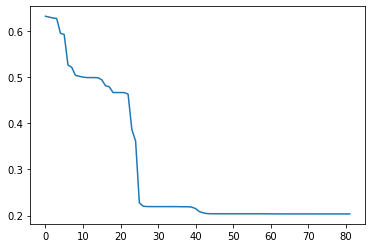

0.20349770159076686


In [298]:
theta_init = np.zeros((3, 1))
theta_init = np.squeeze(theta_init)
loss = partial(logistic_loss_theta, X_data, y_data, hypothesis_function)
loss_grad = partial(logistic_loss_theta_grad, X_data, y_data, hypothesis_function)
theta, best_cost = optimize(theta_init, loss, loss_grad, show=True)
print(best_cost)

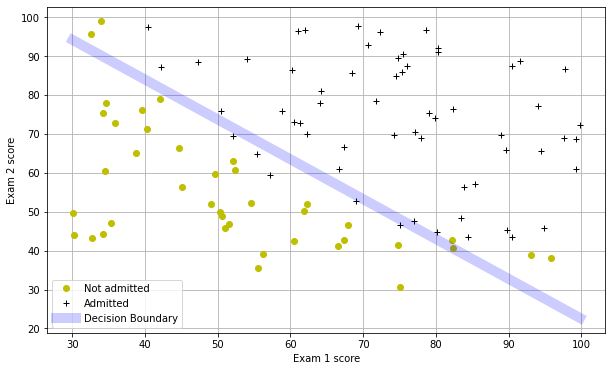

In [299]:
# Plotting decision boundary separating dataset

line_xs = np.array([np.min(X_data[:,0]), np.max(X_data[:,0])])
line_ys = (-1./theta[1])*(theta[2] + theta[0]*line_xs)
plot_data(**student_plotting_spec)
plt.plot(line_xs, line_ys, 'b-', lw=10, alpha=0.2, label='Decision Boundary')
plt.legend()
plt.show()

In [3]:
# Predicting novel datapoint using learned weights 

check_data = np.array([[45., 85., 1]])
print(check_data.shape)
print(hypothesis_function(check_data, theta))

NameError: name 'np' is not defined

In [301]:
def predict(x, theta):

    h0 = hypothesis_function(x,theta)
    predictions = np.zeros(np.shape(h0))
    for i in range(np.prod(np.shape(predictions))):
        if h0[i] > 0.5:
            predictions[i] = 1
            
    return predictions

def accuracy(x, y, theta):

    predictions = predict(x,theta)
    diff = np.squeeze(predictions) - np.squeeze(y)
    return np.prod(np.shape((np.argwhere(diff == 0))))/np.prod(np.shape((y)))
    
print(accuracy(X_data, y_data, theta))

0.89


### 2. Regularized logistic regression

Implementing regularized logistic regression on a dataset consisting of measurements for a series of microchips produced in a fabrication plant. Predictions will determine whether a microchip should be accepted or rejected. 

**Visualizing the data**

Using the prior implementation of generating a scatterplot of the data for visualization of this novel dataset.


In [302]:
X_data_, y_data = read_classification_csv_data('ex2data2.txt')
X_data = X_data_ - X_data_.mean(axis=0)[None, :]
print(X_data.shape, X_data.min(), X_data.max(), X_data.dtype)
print(y_data.shape, y_data.min(), y_data.max(), y_data.dtype)

(118, 2) -0.83007 1.1089 float64
(118, 1) 0.0 1.0 float64
(118, 2) -0.9528415593220338 1.0161210915254237 float64
(118, 1) 0 1 int32


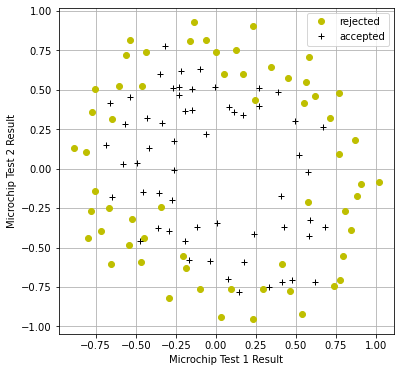

In [303]:
chip_plotting_spec = {
    'X': X_data,
    'y': y_data, 
    'xlabel': 'Microchip Test 1 Result', 
    'ylabel': 'Microchip Test 2 Result',
    'labels': ['rejected', 'accepted'], 
    'markers': ['yo', 'k+'],
    'figsize': (6, 6)
}

plot_data(**chip_plotting_spec)
plt.show()

# NOTE: Dataset is not linearly separable, as evidenced below

**Nonlinear feature mapping**

Polynomial feature mapping to transform the non-linearly separable data into one that is linearly separable. Features  are mapped into all polynomial terms of $x_1$ and $x_2$ up to the sixth power as follows:

\begin{equation}
mapFeature(x) \ = \
\begin{bmatrix}
    1 \\
    x_1 \\
    x_2 \\
    x_1^2 \\
    x_1x_2 \\
    x_2^2 \\
    x_1^3 \\
    \vdots \\
    x_1x_2^5 \\
    x_2^6 \\
\end{bmatrix}
\end{equation}

As a result of this mapping, the vector of two features (the scores
on two QA tests) has been transformed into a 28-dimensional
vector. A logistic regression classifier trained on this
higher-dimension feature vector will have a more complex
decision boundary and will appear nonlinear when drawn in our
2-dimensional plot.

Our hypothesis is now that the probability of chip matfunctioning might be described as

$$ p_i = \sigma(\Phi(x_i)^T \theta)$$

where $\Phi$ denotes the transformation.

In [304]:
from itertools import combinations_with_replacement

def polynomial_feature_map(X_data, degree=20, show_me_ur_powers=False):
    
    assert len(X_data.shape) == 2
    group_size = X_data.shape[1]
    assert group_size == 2

    comb_iterator = combinations_with_replacement(range(degree+1), group_size)
    not_quite_powers = np.array(list(comb_iterator))
    powers_bad_order = not_quite_powers.copy()
    powers_bad_order[:, 1] -= not_quite_powers[:, 0]
    # let's reoder them so that lower power monomials come first
    rising_power_idx = np.argsort(powers_bad_order.sum(axis=1))
    powers = powers_bad_order[rising_power_idx]
    
    if show_me_ur_powers is True:
        print(powers.T)
        print('total power per monomial', powers.sum(axis=1))
        
    X_with_powers = np.power(X_data[:, :, None], powers.T[None])
    X_poly = np.prod(X_with_powers, axis=1)
    return X_poly

X_pf = polynomial_feature_map(X_data, show_me_ur_powers=True)

[[ 0  0  1  0  2  1  0  2  3  1  4  2  1  3  0  5  3  0  2  4  1  0  6  2
   5  4  3  1  4  0  1  2  6  7  3  5  2  3  4  6  8  5  7  0  1  4  7  3
   6  9  8  0  2  1  5  9  3  5  7  8  4 10  6  1  0  2  0  9  1  4  5  2
  10  7  8  6 11  3  7  0  1  9 12  4  6  2  8 11 10  3  5  6 13  1  5  7
   9  8  4 12  2 10  0 11  3  0 12 11 14 10  9  7  6  8 13  4  2  3  1  5
   5  4  9  0 15 14  7  1 10  8  3  2 11  6 12 13  8  3 11  2 14  9 12 13
  10 16  4  0  6  5  1 15  7 12  5  2 13 11  6 15  3 10  7  0  1 16 14  8
   4  9 17  5 12  2  4  8 14 13 16 11  9  6 15  0  1 10  3 18  7 17 15 13
  14 17 19 18 16  2 12  3  1  4  5  0  7  8  6  9 10 11 11 18  3  1 17 10
   4 16 13  5  0 19 15 12  6  9  7 14  2  8 20]
 [ 0  1  0  2  0  1  3  1  0  2  0  2  3  1  4  0  2  5  3  1  4  6  0  4
   1  2  3  5  3  7  6  5  1  0  4  2  6  5  4  2  0  3  1  8  7  5  2  6
   3  0  1  9  7  8  4  1  7  5  3  2  6  0  4  9 10  8 11  2 10  7  6  9
   1  4  3  5  0  8  5 12 11  3  0  8  6 10  4  1  2  9  7  7  0

**Cost function and gradient**

The regularized cost function in logistic regression is:

$J(\theta) \ = \ [ \ \frac{1}{m} \ \sum_{i=1}^{m} \ [ \ -y^{(i)} log(h_\theta(x^{(i)})) \ - \ (1 - y^{(i)})log(1-h_\theta(x^{(i)})) \ ] \ ] \ + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2 $

and the gradient of the above cost function is:

$\frac{\partial J(\theta)}{\partial \theta_{0}} \ = \ \frac{1}{m} \ \sum_{i=1}^{m} \ (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)} \quad \quad \quad \quad \quad \quad$ for $\quad j=0$

$\frac{\partial J(\theta)}{\partial \theta_{j}} \ = \ (\frac{1}{m} \ \sum_{i=1}^{m} \ (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)}) + \frac{\lambda}{m}\theta_j \quad \quad \quad$ for $\quad j \ge 1$


**Implementing regularized logistic regression**

Re-implement computeCost with regularization.

In [305]:
def logistic_loss_theta_w_reg(x, y, h, theta, lambda_=0.0):

    theta = theta.reshape((-1,1))
    return binary_logistic_loss(y, h(x, theta)) + (lambda_/(y.shape[0]*2))*np.sum(theta**2)
    
def logistic_loss_theta_w_reg_grad(x, y, h, theta, lambda_=0.0): 
    
    theta = theta.reshape((-1,1))
    y_pred = h(x, theta)

    y = np.squeeze(y)
    theta_ = np.copy(theta)
    theta_[0] = 0
    point_wise_grads = np.reshape((y_pred-y), [np.shape(y_pred-y)[0],1])*x
    grad = np.mean(point_wise_grads, axis=0)[:, None]  + theta_*(lambda_/y.shape[0])
    grad = np.squeeze(grad)
    return grad

Once you are done, you will call your cost function using the initial value of
θ (initialized to all zeros). You should see that the cost is about 0.693. 

0.6931471805599454
[ 8.47457627e-03 -1.47393694e-03  1.83238652e-02  3.79204875e-02
  4.83116870e-02  8.14194228e-03  2.74281128e-03 -2.78183863e-03
  1.02502549e-02  2.53327158e-03  3.62206863e-02  1.14745376e-02
 -5.13006494e-04 -7.37665567e-04  2.96926570e-02  9.66227378e-03
  1.26710268e-03  5.83282025e-04 -7.50311428e-04 -2.66858278e-03
  1.96894912e-03  2.22460292e-02  2.61849067e-02  5.14792073e-03
 -1.80202003e-03  5.56307799e-03 -1.21167516e-03 -2.15775754e-03
 -7.77390798e-04 -9.97158003e-04  1.71369098e-03 -6.27268614e-04
 -2.22430409e-03  9.08105468e-03  8.49610910e-04  1.01196534e-03
  2.91086360e-03 -1.05308072e-03  2.03649298e-03  3.01185527e-03
  1.95553205e-02 -8.02388158e-04 -1.74538564e-03  1.70850907e-02
 -2.24318631e-03 -4.29158120e-04  7.52146991e-04  5.96787640e-04
 -6.12485717e-04  8.44926264e-03 -1.72286617e-03 -1.85306005e-03
 -5.83990046e-04  1.55326398e-03  5.26695294e-04 -1.48962270e-03
 -7.85026484e-04 -5.21056659e-04 -5.06525809e-04  1.75113347e-03
  9.94

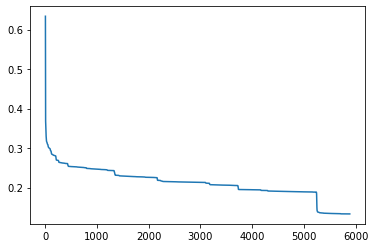

best loss 0.13314527704014661
best acc 0.9322033898305084


In [306]:
theta_init = np.zeros((X_pf.shape[1], 1))
print(logistic_loss_theta_w_reg(X_pf, y_data, hypothesis_function, theta_init, lambda_=2.0))
print(logistic_loss_theta_w_reg_grad(X_pf, y_data, hypothesis_function, theta_init, lambda_=0.1))

loss = partial(logistic_loss_theta_w_reg, X_pf, y_data, hypothesis_function)
loss_grad = partial(logistic_loss_theta_w_reg_grad, X_pf, y_data, hypothesis_function)

theta, best_cost = optimize(theta_init, loss, loss_grad, show=True)

print('best loss', best_cost)
print('best acc', accuracy(X_pf, y_data, theta))



**Plotting the decision boundary**

To help visualize the model learned by this classifier, the following function
*plotBoundary* plots the (non-linear) decision boundary that separates the
positive and negative examples. 

In [307]:
def plot_boundary(theta, ax=None):
    """
    Function to plot the decision boundary for arbitrary theta, X, y, lambda value
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    ax = ax or plt.gca()
    x_range = np.linspace(-1,1.5,50)
    y_range = np.linspace(-1,1.5,50)
    xx, yy = np.meshgrid(x_range, y_range)
    X_fake = np.stack([xx, yy]).reshape(2, -1).T
    X_fake_fm = polynomial_feature_map(X_fake)
    y_pred_fake = hypothesis_function(X_fake_fm, theta)
    return ax.contour( x_range, y_range, y_pred_fake.reshape(50, 50).T, [0.5])

**Plot Decision Boundaries**

Four subplots of the decision boundary for the following values of the regularization parameter: $\lambda \ = \ 0, 1, 5, 10$. 


[(34, 231), (34, 1), (84, 231), (84, 1)]


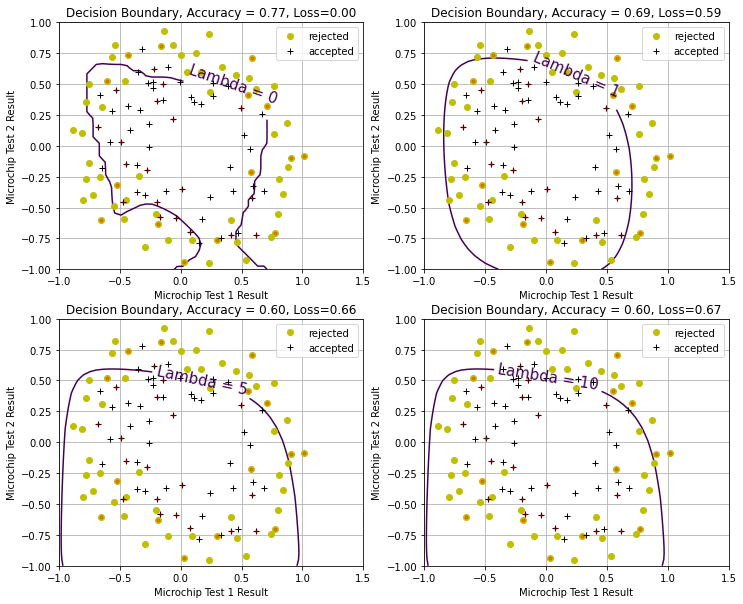

In [308]:
np.random.seed(2)
train_idx_mask = np.random.rand(X_pf.shape[0]) < 0.3
X_pf_train, y_train = X_pf[train_idx_mask], y_data[train_idx_mask]
X_pf_test, y_test = X_pf[~train_idx_mask], y_data[~train_idx_mask]
print([x.shape for x in (X_pf_train, y_train, X_pf_test, y_test)])

def silent_optimize_w_lambda(lambda_):
    theta_init = np.zeros((X_pf.shape[1], 1))
    data = (X_pf_train, y_train, hypothesis_function)
    loss = partial(logistic_loss_theta_w_reg, *data, lambda_=lambda_)
    loss_grad = partial(logistic_loss_theta_w_reg_grad, *data, lambda_=lambda_)
    theta, final_loss = optimize(theta_init, loss, loss_grad, optimizer_fn=None, max_iter=1000, print_every=0, show=False)
    return theta, final_loss

thetas = []
plt.figure(figsize=(12,10))

chip_plotting_spec['figsize'] = None

for id_, lambda_ in enumerate([0, 1, 5, 10]):
    ax = plt.subplot(2, 2, id_+1)
    theta, final_loss = silent_optimize_w_lambda(lambda_)
    thetas.append(theta)
    cnt = plot_boundary(theta, ax)
    plot_data(**chip_plotting_spec)
    cnt_fmt = {0.5: 'Lambda = %d' % lambda_}
    ax.clabel(cnt, inline=1, fontsize=15, fmt=cnt_fmt)
    acc = accuracy(X_pf_test, y_test, theta)
    ax.set_title("Decision Boundary, Accuracy = %.2f, Loss=%.2f" % (acc, final_loss))
    ax.set_ylim((-1,1))
    ax.plot(*X_data[train_idx_mask].T, 'r.', alpha=0.3)
    
plt.show()